# <center>Классификация знаменитых личностей по лицу

<center><img src='./img/cv_project1_1_1.png'></img></center>


>**Задача проекта** - классификация пяти знаменитых личностей (Билл Гейтс, Илон Маск, Джефф Безос, Марк Цукерберг, Стив Джобс) по изображению лица с использованием глубокого обучения.

## <center>Знакомство с данными и подготовка датасета</center>

Для начала импортируем необходимые библиотеки и фреймворки. Будем использовать *PyTorch* для глубокого обучения

In [1]:
import os
from tqdm import tqdm
# Data processing
import pandas as pd
import numpy as np
# DL/ML
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2, InterpolationMode
from torchvision import io, models
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from sklearn.model_selection import StratifiedShuffleSplit
# Visualization 
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
# Plotly configuration
pio.renderers.default = 'png'
pio.templates.default = 'plotly_dark'
# Project constants
DATA_TRAIN_PATH = './data/train/'
DATA_TEST_PATH = './data/valid/'
BATCH_SIZE = 32
RANDOM_STATE = 42
NN_INPUT = (224, 224)
N_CLASSES = len(os.listdir(DATA_TRAIN_PATH))
# Check if GPU available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Available accelerator: {DEVICE}')

Available accelerator: cuda


Напишем собственный класс датасета, который может возвращать как обучающую выборку, так и валидационную с помощью стратифицированного разбиения

In [2]:
class CustomImageDataset(Dataset):
    def __init__(
        self, 
        data_path,
        split=None, 
        random_state=42,
        test_size=0.2,
        transform=None,
        device='cpu'
        ):
        """Dataset for image classification

        Args:
            `data_path` (`str`): path to data in format `./data/train/`
            ```
            data
            └── train
                ├── bill_gates
                ├── elon_musk
                ├── jeff_bezos
                ├── mark_zuckerberg
                └── steve_jobs
            ```
            `split` ([`None`, `str`], optional): Splits data to `train` and `test`. Defaults to `None`.
            `random_state` (`float`, optional): Random state for group splitting. Defaults to `42`
            `test_size` (`float`, optional): Size of test data, when `split` is not `None`. Defaults to `0.2`
            `transform` (`torchvision.transforms.v2.Compose`, optional): Augmentation and/or normalization. Defaults to `None`.
            `device` (`str`, optional): Move data to `cuda` or `cpu`. Defaults to `cpu`.
            
        """
        super().__init__()
        self.data_path = data_path
        self.split = split
        self.transform = transform
        self.device = device
        # Label encoding + inverse transform dict
        self.classes = os.listdir(self.data_path)
        self.classes_dict = dict(zip(self.classes, range(len(self.classes))))
        self.classes_dict_inverse = dict(zip(self.classes_dict.values(), self.classes_dict.keys()))
        # Add all samples to list in format (img_name.jpg, class_name)
        self.items = []
        for class_ in self.classes:
            for item in os.listdir(self.data_path+class_):
                self.items.append((item, class_))
        # Split data to train and valid samples
        if split:
            assert random_state, 'random_state should be passed, if split is not None'
            self.random_state = random_state
            self.test_size = test_size
            self.sss = StratifiedShuffleSplit(n_splits=1, test_size=self.test_size, random_state=self.random_state)
            train_idxs, valid_idxs = list(self.sss.split([item[0] for item in self.items], [item[1] for item in self.items]))[0]
            match split:
                case 'train':
                    self.items = [self.items[train_idx] for train_idx in train_idxs]
                case 'valid':
                    self.items = [self.items[valid_idx] for valid_idx in valid_idxs]
        
            
    def __len__(self):
        return len(self.items)
    
    def __getitem__(self, idx):
        # Get image path and label
        img, label = self.items[idx]
        # Convert image path to tensor
        img = io.read_image(os.path.join(self.data_path, label, img)).to(self.device)
        # Apply transforms to tensor
        if self.transform:
            img = self.transform(img)
        # Encode class name
        label = torch.tensor(self.classes_dict[label]).to(self.device)
        return img, label

Сделаем аугментацию+нормализацию данных для обучающей выборки, а так же нормализуем валидационную и тестовую. Для нормализации используем среднее и стандартное отклонение, посчитанные для *ImageNet*.

In [3]:
# ImageNet mean and std
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
# Normalize images with ImageNet mean and std
normalize = v2.Normalize(mean=mean, std=std)
# Inversion normalize to visualize 
inv_normalize = v2.Normalize(
   mean = [-m/s for m, s in zip(mean, std)],
   std = [1/s for s in std]
)
# Transforms for valid/test samples
base_transforms = v2.Compose([
    v2.Resize(NN_INPUT, antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    normalize
])
# Transforms for train sample
train_transforms = v2.Compose([
    # Augmentation
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomAutocontrast(p=0.5),
    v2.RandomPerspective(distortion_scale=0.2, p=0.5),
    v2.RandomRotation(degrees=20, interpolation=InterpolationMode.BILINEAR),
    # Resize and normalize
    base_transforms
])
# Split datasets to train, valid and test, move it to GPU if available
train_dataset = CustomImageDataset(
    DATA_TRAIN_PATH, 
    split='train', 
    random_state=RANDOM_STATE,
    transform=train_transforms,
    device=DEVICE
)
valid_dataset = CustomImageDataset(
    DATA_TRAIN_PATH, 
    split='valid',
    random_state=RANDOM_STATE,
    transform=base_transforms,
    device=DEVICE
)
test_dataset = CustomImageDataset(
    DATA_TEST_PATH, 
    transform=base_transforms,
    device=DEVICE
)
# Print results
print(
    f'Количество обучающих примеров: {len(train_dataset)}',
    f'Количество валидационных примеров: {len(valid_dataset)}',
    f'Количество тестовых примеров: {len(test_dataset)}', sep='\n'
)

Количество обучающих примеров: 2400
Количество валидационных примеров: 600
Количество тестовых примеров: 914


Напишем даталоадеры для каждой выборки с заранее выбранным `BATCH_SIZE`, в моём случае это `32`

In [4]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f'Batch shape: {next(iter(train_loader))[0].shape}')

Batch shape: torch.Size([32, 3, 224, 224])


Напишем 2 функции:
1. `inverse_transform_labels` - обратное кодирование меток классов из цифр в строки

2. `visualize_batch` - визуализация примеров из батча с соответствующими метками класса.

Визуализируем **обучающую выборку**, к которой применяется **аугментация**, так что изображения будут немного искажены

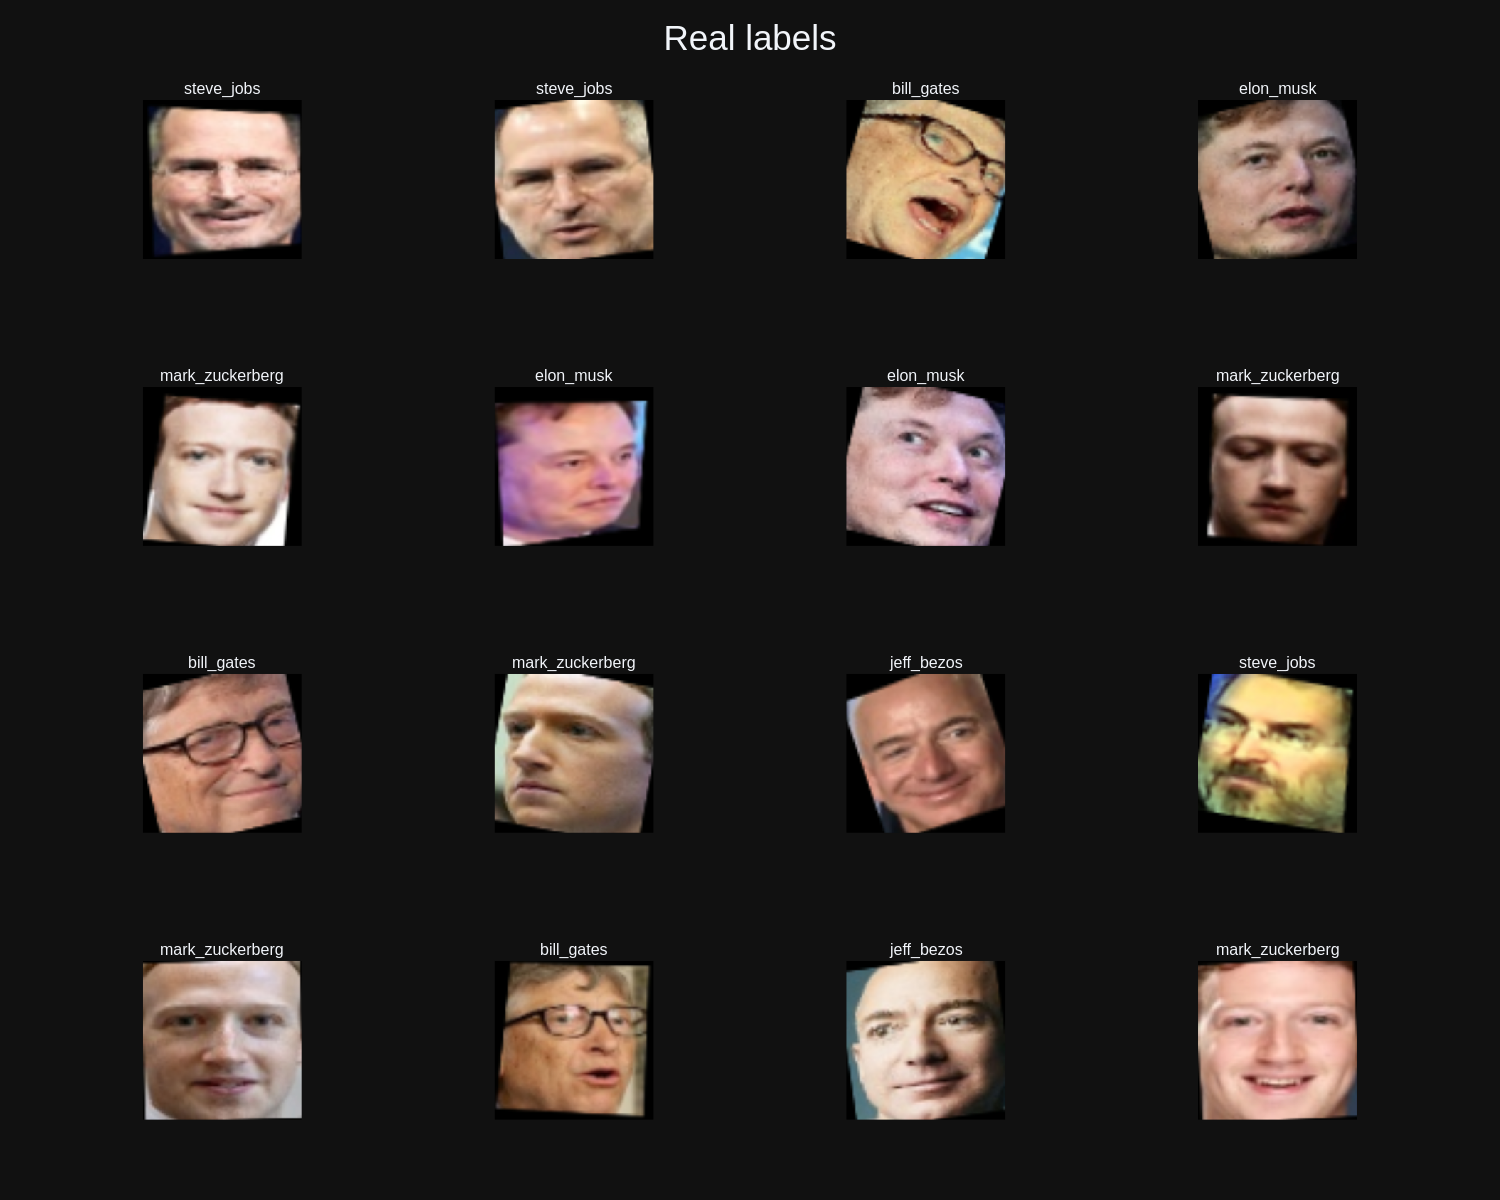

In [5]:
# [0, 1, ...] -> [elon_musk, bill_gates, ...]
inverse_transform_labels = lambda labels: [train_dataset.classes_dict_inverse[label] for label in labels.cpu().numpy()]

def visualize_batch(loader, model=None, rows=4, cols=4):
    
    images, labels = next(iter(loader))
    if model is not None:
        preds = model(images).argmax(1)
        sub_titles = inverse_transform_labels(preds)
        title = 'Predicted labels'
    else:
        sub_titles = inverse_transform_labels(labels)
        title = 'Real labels'
    grid = make_subplots(
        rows=rows,
        cols=cols,
        subplot_titles=sub_titles
    )
    iterators = [
        range(rows * cols), # total images to display
        sorted(list(range(1, rows + 1)) * cols), # iteration over rows
        list(range(1, cols + 1)) * rows # iteraion over columns
    ]
    for n_iter, row, col in zip(*iterators):
        grid.add_trace(
            # Un-normalize and change image shape (C, H, W) -> (H, W, C)
            px.imshow(inv_normalize(images[n_iter]).cpu().permute(1, 2, 0)).data[0],
            row=row,
            col=col
        )
    grid.update_xaxes(
        visible=False
    ).update_yaxes(
        visible=False
    ).update_layout(
        height=1200,
        width=1500,
        title=title,
        title_x=0.5,
        font_size=25
    ).show()
    
visualize_batch(train_loader)

## <center>Визуальный анализ данных

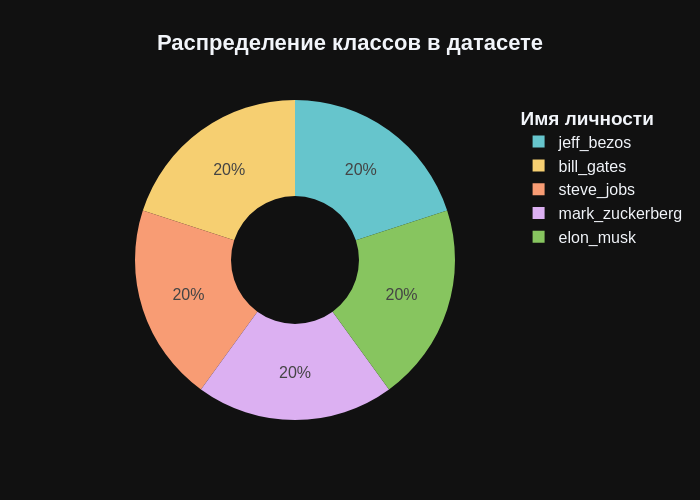

In [6]:
classes_count = pd.DataFrame(
    [(directory, len(os.listdir(DATA_TRAIN_PATH+directory))) 
    for directory in os.listdir(DATA_TRAIN_PATH)], 
    columns=['name', 'count']
)
px.pie(
    data_frame=classes_count, 
    names='name', 
    values='count', 
    hole=0.4,
    title='<b>Распределение классов в датасете</b>',
    color_discrete_sequence=px.colors.qualitative.Pastel,
    height=500,
    width=700
).update_layout(
    legend_title='<b>Имя личности</b>',
    font=dict(size=16),
    title_x=0.5
)

Все классы в обучающем наборе данных **идеально сбалансированы**, так что нет необходимости изменять веса классов под обучение модели

## <center>Deep Learning</center>
Будем использовать **предобученную** модель *ResNeXt* с 50-ю слоями

In [7]:
# Download ResNeXt with 50 layers
resnext50 = models.resnext50_32x4d(weights='DEFAULT')

В оригинальной модели количество выходных нейронов - $1000$. В нашей же задаче всего $5$ классов, поэтому **изменим последний слой**, заменив количество выходов. *Softmax* не нужно добавлять, потому что `nn.CrossEntropyLoss` итак делает это преобразование. Также переместим модель на *GPU*, если возможно

In [8]:
# Change last layer for current task
fc_input = resnext50.fc.in_features
resnext50.fc = nn.Linear(fc_input, N_CLASSES, bias=True)
# Move model to GPU if available
resnext50 = resnext50.to(DEVICE)

Инициализируем **функцию потерь** (перекрёстная энтропия) и **оптимизатор** (стохастический градиентный спуск с *Momentum*). **Темп обучения** возьмем $10^{-5}$, т.к. мы не с нуля учим модель, а используем подход *fine-tuning*, так что надо лишь немного подкорректировать веса под текущую задачу. 

Сначала не будем замораживать никакие слои сети. Если метрики качества будут недостаточно удовлетворительными (например, $\text{Accuracy} \leq 0.85$), то можно будет попробовать этот способ

In [9]:
# Loss
criterion = nn.CrossEntropyLoss().to(DEVICE)
# Low learning rate for fine-tuning with Adam
learning_rate = 1e-5
optimizer = torch.optim.Adam(
    resnext50.parameters(),
    lr=learning_rate
)
# Classification metrics
accuracy_score = MulticlassAccuracy(N_CLASSES).to(DEVICE)
f1_score = MulticlassF1Score(N_CLASSES).to(DEVICE)

**Дообучаем модель** на $30$-ти эпохах. Все метрики для каждой эпохи (как с обучения, так и с валидации) будем хранить в словаре `history`. Также сохраним чекпоинт `best_net_state`, чтобы не потерять веса наилучшей модели из всех эпох.

In [10]:
# Num of epochs
epochs = 30
# History with metrics
history = dict(
    train_loss=[],
    train_acc=[],
    train_f1=[],
    val_loss=[],
    val_acc=[],
    val_f1=[]
)
# Start training and evaluation
for epoch in range(epochs):
    # Initial state of train epoch metrics
    train_epoch_loss = .0
    train_epoch_acc = .0
    train_epoch_f1 = .0
    # Initial state of valid epoch metrics
    valid_epoch_loss = .0
    valid_epoch_acc = .0
    valid_epoch_f1 = .0
    # Checkpoint with best weights 
    best_net_state = resnext50.state_dict()
    
    # TRAIN
    for inputs_train, labels_train in train_loader:
        # Zero gradients for every batch
        optimizer.zero_grad()
        # Get train outputs
        outputs_train = resnext50(inputs_train)
        # Compute train CrossEntropy
        loss_train = criterion(outputs_train, labels_train)
        # Compute gradients via backpropagation
        loss_train.backward()
        # Update gradients
        optimizer.step()
        # Accumulate train metrics from all batches for epoch
        train_epoch_loss += loss_train
        train_epoch_acc += accuracy_score(outputs_train, labels_train)
        train_epoch_f1 += f1_score(outputs_train, labels_train)
    # Compute average train metrics for epoch
    avg_train_epoch_loss = train_epoch_loss / len(train_loader)
    avg_train_epoch_acc = train_epoch_acc / len(train_loader)
    avg_train_epoch_f1 = train_epoch_f1 / len(train_loader)
    # Add train metrics to dict
    history['train_loss'].append(avg_train_epoch_loss.cpu().detach().numpy())
    history['train_acc'].append(avg_train_epoch_acc.cpu().numpy())
    history['train_f1'].append(avg_train_epoch_f1.cpu().numpy())
    
    # VALIDATION
    for inputs_valid, labels_valid in valid_loader:
        # Compute valid outputs and loss
        with torch.no_grad():
            outputs_valid = resnext50(inputs_valid)
            loss_valid = criterion(outputs_valid, labels_valid)
        # Accumulate valid metrics    
        valid_epoch_loss += loss_valid
        valid_epoch_acc += accuracy_score(outputs_valid, labels_valid)
        valid_epoch_f1 += f1_score(outputs_valid, labels_valid)
    # Compute average valid metrics for epoch
    avg_valid_epoch_loss = valid_epoch_loss / len(valid_loader)
    avg_valid_epoch_acc = valid_epoch_acc / len(valid_loader)    
    avg_valid_epoch_f1 = valid_epoch_f1 / len(valid_loader)
    # Add valid metrics to dict
    history['val_loss'].append(avg_valid_epoch_loss.cpu().detach().numpy())
    history['val_acc'].append(avg_valid_epoch_acc.cpu().numpy())
    history['val_f1'].append(avg_valid_epoch_f1.cpu().numpy())
    # Get best epoch based on max accuracy on validation
    best_epoch = np.argmax(history['val_acc'])
    # Update best weights dict
    if best_epoch == epoch:
        best_net_state = resnext50.state_dict()
    # Verbose
    print(
        f'[Epoch {epoch+1}]\n',
        f'train loss: {avg_train_epoch_loss:.3f} | ',
        f'train acc: {avg_train_epoch_acc:.3f} | ',
        f'train f1: {avg_train_epoch_f1:.3f}\n'
        f'valid loss: {avg_valid_epoch_loss:.3f} | ',
        f'valid acc: {avg_valid_epoch_acc:.3f} | ',
        f'valid f1: {avg_valid_epoch_f1:.3f}\n',
        f'best epoch: {best_epoch+1}\n\n',
        sep='', end=''
    )
# Load best weights    
resnext50.load_state_dict(best_net_state)

[Epoch 1]
train loss: 1.559 | train acc: 0.338 | train f1: 0.309
valid loss: 1.527 | valid acc: 0.370 | valid f1: 0.348
best epoch: 1

[Epoch 2]
train loss: 1.387 | train acc: 0.595 | train f1: 0.563
valid loss: 1.357 | valid acc: 0.571 | valid f1: 0.544
best epoch: 2

[Epoch 3]
train loss: 1.099 | train acc: 0.737 | train f1: 0.712
valid loss: 1.119 | valid acc: 0.691 | valid f1: 0.667
best epoch: 3

[Epoch 4]
train loss: 0.811 | train acc: 0.822 | train f1: 0.794
valid loss: 0.904 | valid acc: 0.807 | valid f1: 0.777
best epoch: 4

[Epoch 5]
train loss: 0.573 | train acc: 0.880 | train f1: 0.857
valid loss: 0.710 | valid acc: 0.845 | valid f1: 0.821
best epoch: 5

[Epoch 6]
train loss: 0.386 | train acc: 0.913 | train f1: 0.894
valid loss: 0.555 | valid acc: 0.887 | valid f1: 0.865
best epoch: 6

[Epoch 7]
train loss: 0.280 | train acc: 0.942 | train f1: 0.926
valid loss: 0.453 | valid acc: 0.903 | valid f1: 0.885
best epoch: 7

[Epoch 8]
train loss: 0.224 | train acc: 0.949 | train 

<All keys matched successfully>

Напишем функцию для визуализации истории обучения сети

In [11]:
def visualize_history(history):
    # Make DataFrame with metrics for easy visualization 
    history_df = pd.DataFrame({
        'loss': list(history['train_loss']) + list(history['val_loss']),
        'accuracy': list(history['train_acc']) + list(history['val_acc']),
        'sample': ['train']*epochs + ['validation']*epochs,
        'epoch': list(range(1, epochs+1))*2
    })
    # Match correct dtypes
    for vec_float in ['loss', 'accuracy']:
        history_df[vec_float] = history_df[vec_float].astype(float)
    history_df['sample'] = history_df['sample'].astype(object)
    history_df['epoch'] = history_df['epoch'].astype(int)
    # X and Y coordinates for annotations
    best_epoch_loss = history_df[history_df['sample'] == 'validation']['loss'].argmin() + 1
    best_epoch_acc = history_df[history_df['sample'] == 'validation']['accuracy'].argmax() + 1
    min_loss = history_df[history_df['sample'] == 'validation']['loss'].min()
    max_accuracy = history_df[history_df['sample'] == 'validation']['accuracy'].max()
    # Loss plot
    px.line(
        data_frame=history_df,
        x='epoch',
        y='loss',
        color='sample',
        width=900,
        height=600,
        title='История изменения функции потерь в зависимости от эпохи'
    ).update_layout(
        font=dict(size=15),
        xaxis=dict(
            tickmode='linear',
            tick0=1,
            dtick=1
        )
    ).add_vline(
        x=best_epoch_loss,
        line_dash='dash',
        opacity=0.5
    ).add_hline(
        y=min_loss,
        line_dash='dash',
        opacity=0.5
    ).add_annotation(
        x=best_epoch_loss,
        y=min_loss,
        text=f'min loss={min_loss:.3f}',
        arrowwidth=2,
        ax=20,
        arrowhead=2,
        bgcolor='white',
        font_color='black',
        ay=50
    ).show()
    # Accuracy plot
    px.line(
        data_frame=history_df,
        x='epoch',
        y='accuracy',
        color='sample',
        width=900,
        height=600,
        title='История изменения метрики <i>accuracy</i> в зависимости от эпохи'
    ).update_layout(
        font=dict(size=15),
        xaxis=dict(
            tickmode='linear',
            tick0=1,
            dtick=1
        )
    ).add_vline(
        x=best_epoch_acc,
        line_dash='dash',
        opacity=0.5
    ).add_hline(
        y=max_accuracy,
        line_dash='dash',
        opacity=0.5
    ).add_annotation(
        x=best_epoch_acc,
        y=max_accuracy,
        text=f'max accuracy={max_accuracy:.3f}',
        arrowwidth=2,
        ax=20,
        arrowhead=2,
        bgcolor='white',
        font_color='black',
        ay=-30
    ).show()

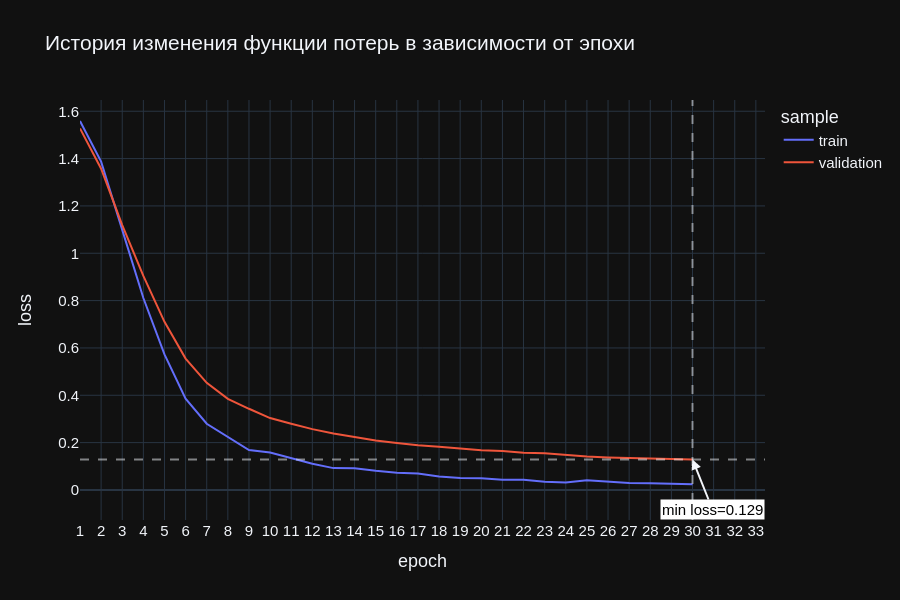

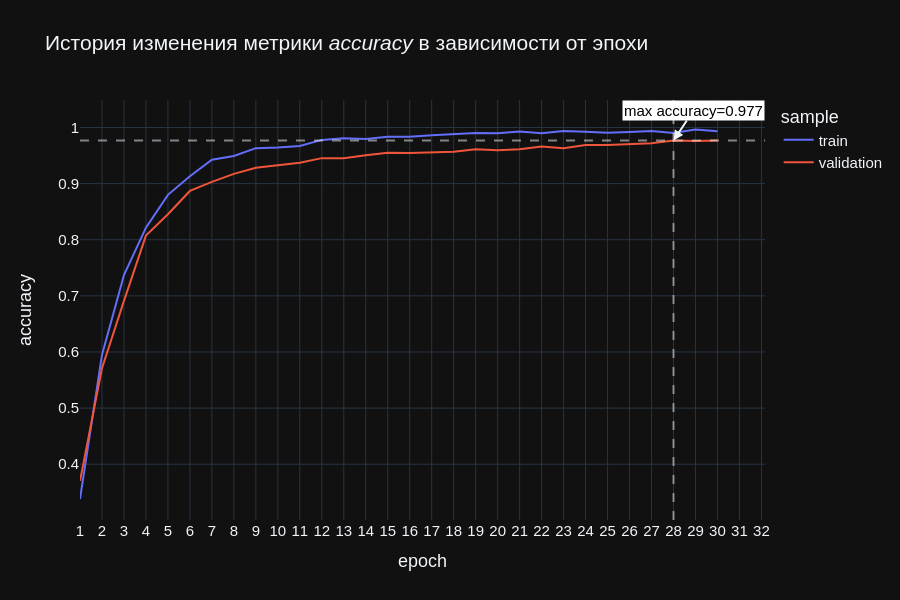

In [12]:
visualize_history(history)

Видно, что на 28-й эпохе мы получили $\text{Accuracy} \approx 0.98$, что является практически идеальным показателем в задаче классификации. Также $F_1\text{-score} \approx 0.97$, так что можно с уверенностью сказать, что сеть не переобучилась и метрики $\text{Precision}$ и $\text{Recall}$ близки к $1$. Сохраним веса модели в файл

In [13]:
save_path = './model/model.pt'
torch.save(resnext50.state_dict(), save_path)

### Проверка на тестовых данных

In [24]:
# Enable evaluation mode and compute metrics for test sample
resnext50 = resnext50.eval()
test_epoch_loss = .0
test_epoch_acc = .0
test_epoch_f1 = .0
confusion_matrix = torch.zeros((N_CLASSES, N_CLASSES)).to(DEVICE)
compute_conf_matrix = MulticlassConfusionMatrix(N_CLASSES).to(DEVICE)
for inputs_test, labels_test in tqdm(test_loader):
# Compute test outputs and loss
    with torch.no_grad():
        outputs_test = resnext50(inputs_test)
        loss_test = criterion(outputs_test, labels_test)
    # Accumulate test metrics    
    test_epoch_loss += loss_test
    test_epoch_acc += accuracy_score(outputs_test, labels_test)
    test_epoch_f1 += f1_score(outputs_test, labels_test)
    confusion_matrix += compute_conf_matrix(outputs_test, labels_test)
# Compute average test metrics for epoch
avg_test_epoch_loss = test_epoch_loss / len(test_loader)
avg_test_epoch_acc = test_epoch_acc / len(test_loader)    
avg_test_epoch_f1 = test_epoch_f1 / len(test_loader)
# Print metrics
print(
    f'Test loss: {avg_test_epoch_loss:.3f}\n',
    f'Test accuracy: {avg_test_epoch_acc:.3f}\n',
    f'Test F1-score: {avg_test_epoch_f1:.3f}', sep='', end=''
)

100%|██████████| 29/29 [00:01<00:00, 18.60it/s]

Test loss: 0.068
Test accuracy: 0.972
Test F1-score: 0.967

Визуализируем **матрицу ошибок** (*confusion matrix*) для тестовой выборки

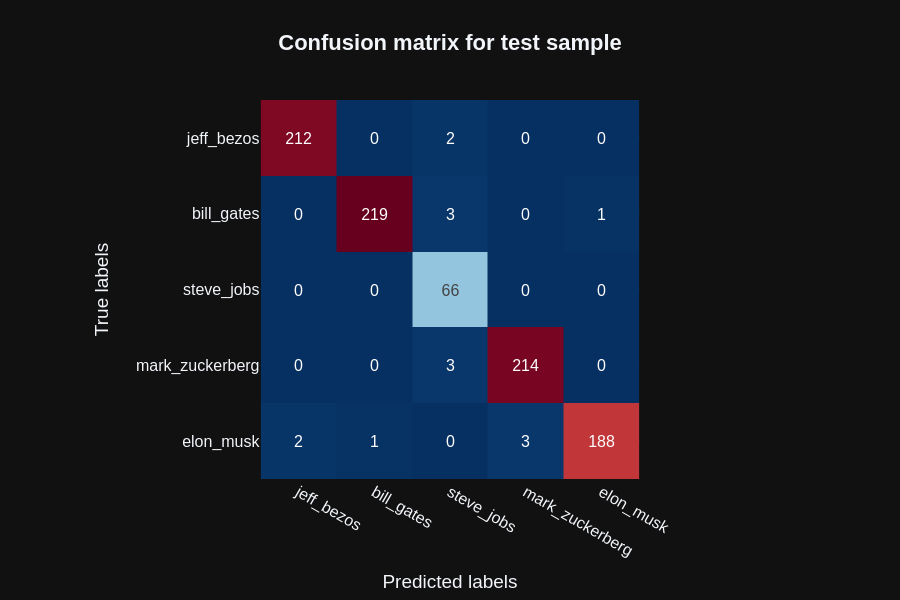

In [45]:
px.imshow(
    img=confusion_matrix.cpu(),
    color_continuous_scale=px.colors.sequential.RdBu_r,
    text_auto=True,
    title='<b>Confusion matrix for test sample',
    height=600,
    width=900,
    x=list(train_dataset.classes_dict.keys()),
    y=list(train_dataset.classes_dict.keys())
).update_layout(
    font=dict(size=16),
    title_x=0.5,
    xaxis_title='Predicted labels',
    yaxis_title='True labels',
    coloraxis_showscale=False
)

На тестовой выборке получаем тоже практически идеальный результат. $\text{Accuracy} \approx 0.97$, $F_1 \text{-score} \approx 0.97$. В матрице ошибок практически все предсказанные классы принадлежат к действительным классам.

Визуализируем часть батча из тестовой выборки с предсказанными метками классов с помощью обученной модели.

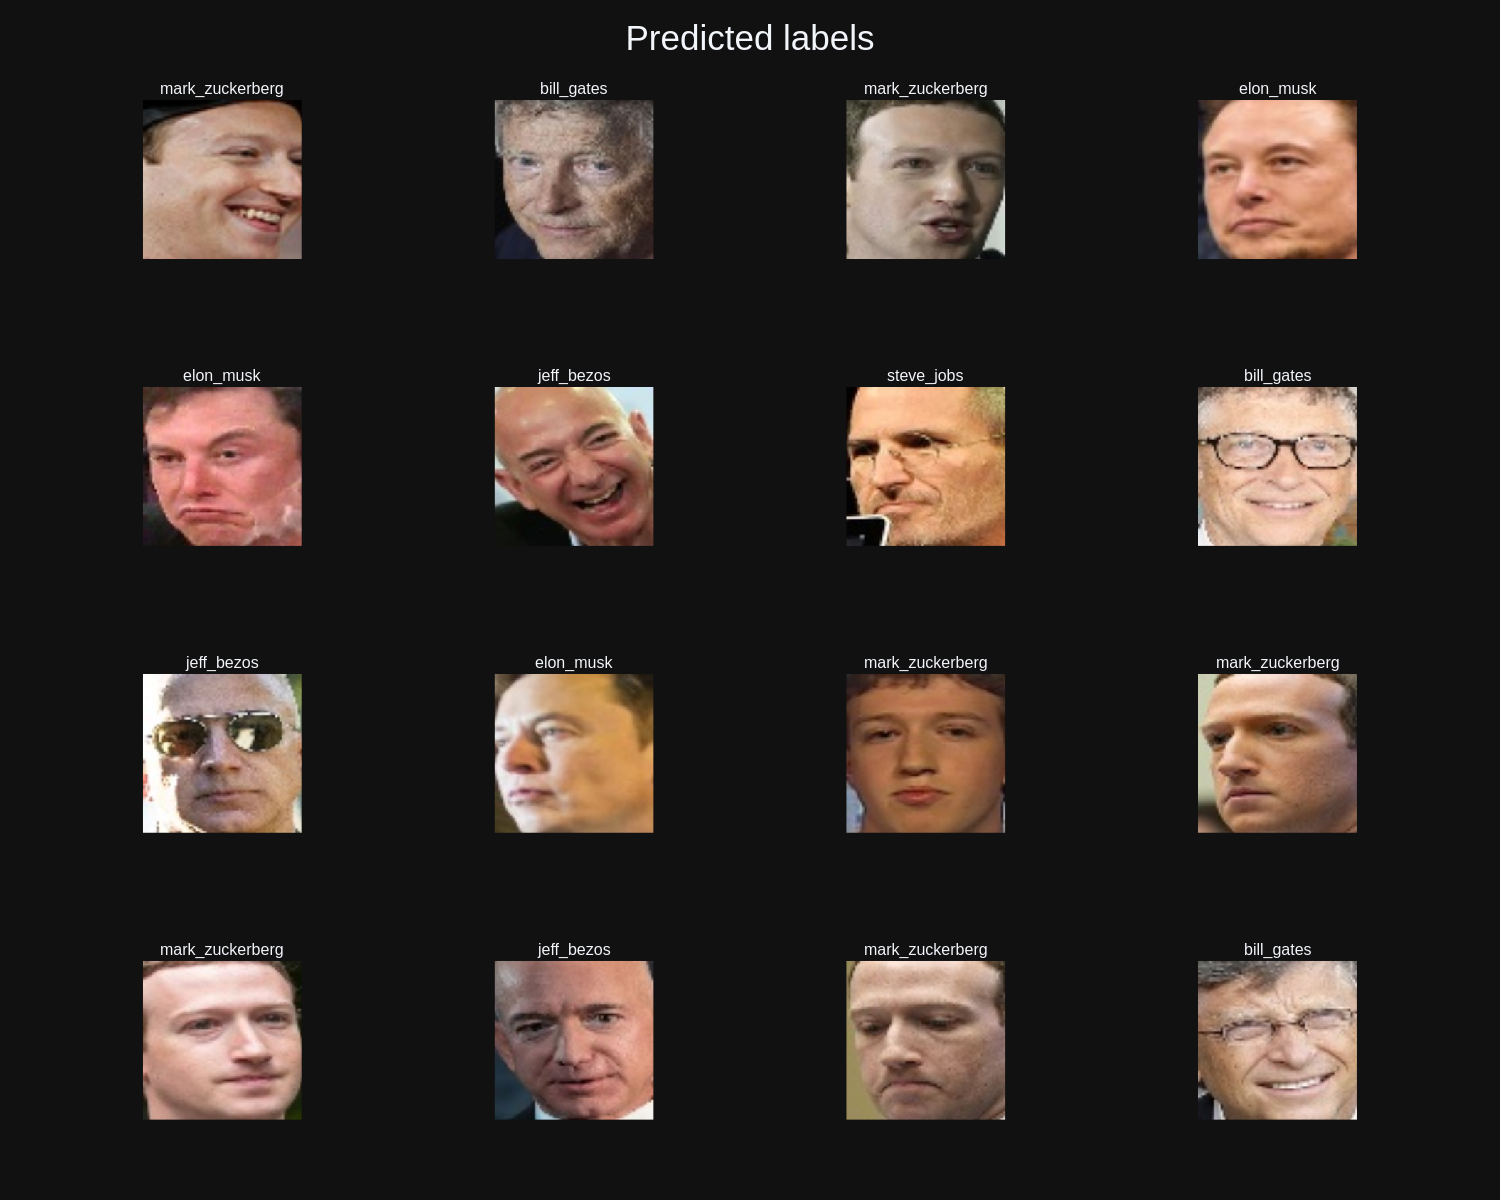

In [15]:
visualize_batch(test_loader, resnext50)

### Загрузка модели из файла

In [26]:
resnext = models.resnext50_32x4d()
# Change last layer for current task
fc_input = resnext.fc.in_features
resnext.fc = nn.Linear(fc_input, 5, bias=True)
# Move model to GPU if available
resnext.load_state_dict(torch.load('./model/model.pt'))
resnext = resnext.to(DEVICE).eval()

### Вывод
*Fine-tuning* предобученной модели *ResNeXt* помог за короткое время научить классификатор лиц известных личностей почти на идеальный результат.